In [ ]:
import csv

with open('scores.csv', 'r') as file:
    reader = csv.reader(file, delimiter='|')
    for data_list in reader:
        print(reader.line_num, end='\t')
        for elem in data_list:
            print(elem, end='\t')
        print()

[1, 2, 4]


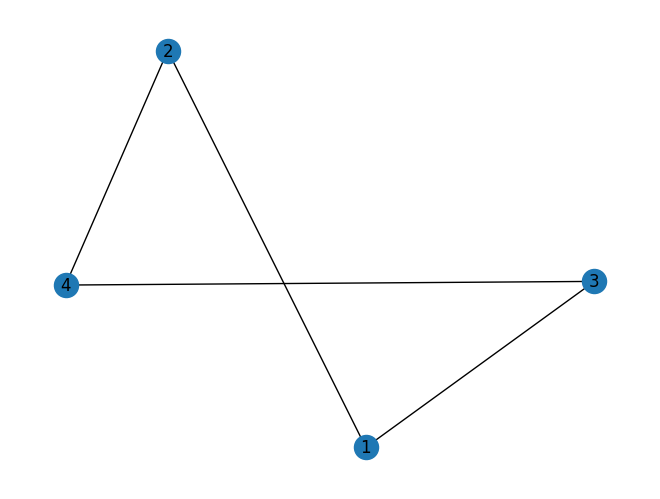

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个无向图对象
G = nx.Graph()
# 添加边到图中：边(1,2), (1,3), (2,4), (3,4)
G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4)])

# 计算并打印从节点1到节点4的最短路径
print(nx.shortest_path(G, source=1, target=4))  # 输出: [1, 2, 4]

# 可视化图结构，显示节点标签
nx.draw(G, with_labels=True)
# 显示图形（会弹出一个窗口显示图形）
plt.show()

In [2]:
import heapq


def prim(graph):
    """
    使用Prim算法计算最小生成树

    参数:
        graph: 图的邻接表表示，格式为{节点: {相邻节点: 边权重}}

    返回:
        最小生成树的边列表，格式为[(起点, 终点, 权重)]
    """
    # 选择第一个节点作为起始点
    start = list(graph.keys())[0]
    # 已访问节点集合，初始只包含起始节点
    visited = {start}
    # 构建边的优先队列，格式为(权重, 起点, 终点)
    edges = [(cost, start, to) for to, cost in graph[start].items()]
    # 将边列表转换为堆（优先队列）
    heapq.heapify(edges)
    # 最小生成树的边列表
    mst = []

    # 当边的优先队列不为空时循环
    while edges:
        # 弹出权重最小的边
        cost, u, v = heapq.heappop(edges)
        # 如果终点还未访问，则将该边加入最小生成树
        if v not in visited:
            # 标记终点为已访问
            visited.add(v)
            # 将边加入最小生成树
            mst.append((u, v, cost))
            # 遍历新添加节点的所有邻居
            for neighbor, cost in graph[v].items():
                # 如果邻居节点未访问，则将对应边加入优先队列
                if neighbor not in visited:
                    heapq.heappush(edges, (cost, v, neighbor))
    return mst


# 示例图，使用邻接表表示
graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 5},
    'C': {'A': 4, 'B': 2, 'D': 1},
    'D': {'B': 5, 'C': 1}
}

# 输出最小生成树
print(prim(graph))  # 输出形式为[(起点, 终点, 权重)]

[('A', 'B', 1), ('B', 'C', 2), ('C', 'D', 1)]


对于 7 个顶点，最多可以有 21 条边
生成具有 7 个顶点和 15 条边的非同构图...


生成图:   0%|          | 0/1000 [00:00<?, ?it/s]

共找到 35 个非同构图
图数量过多，仅显示前 20 个


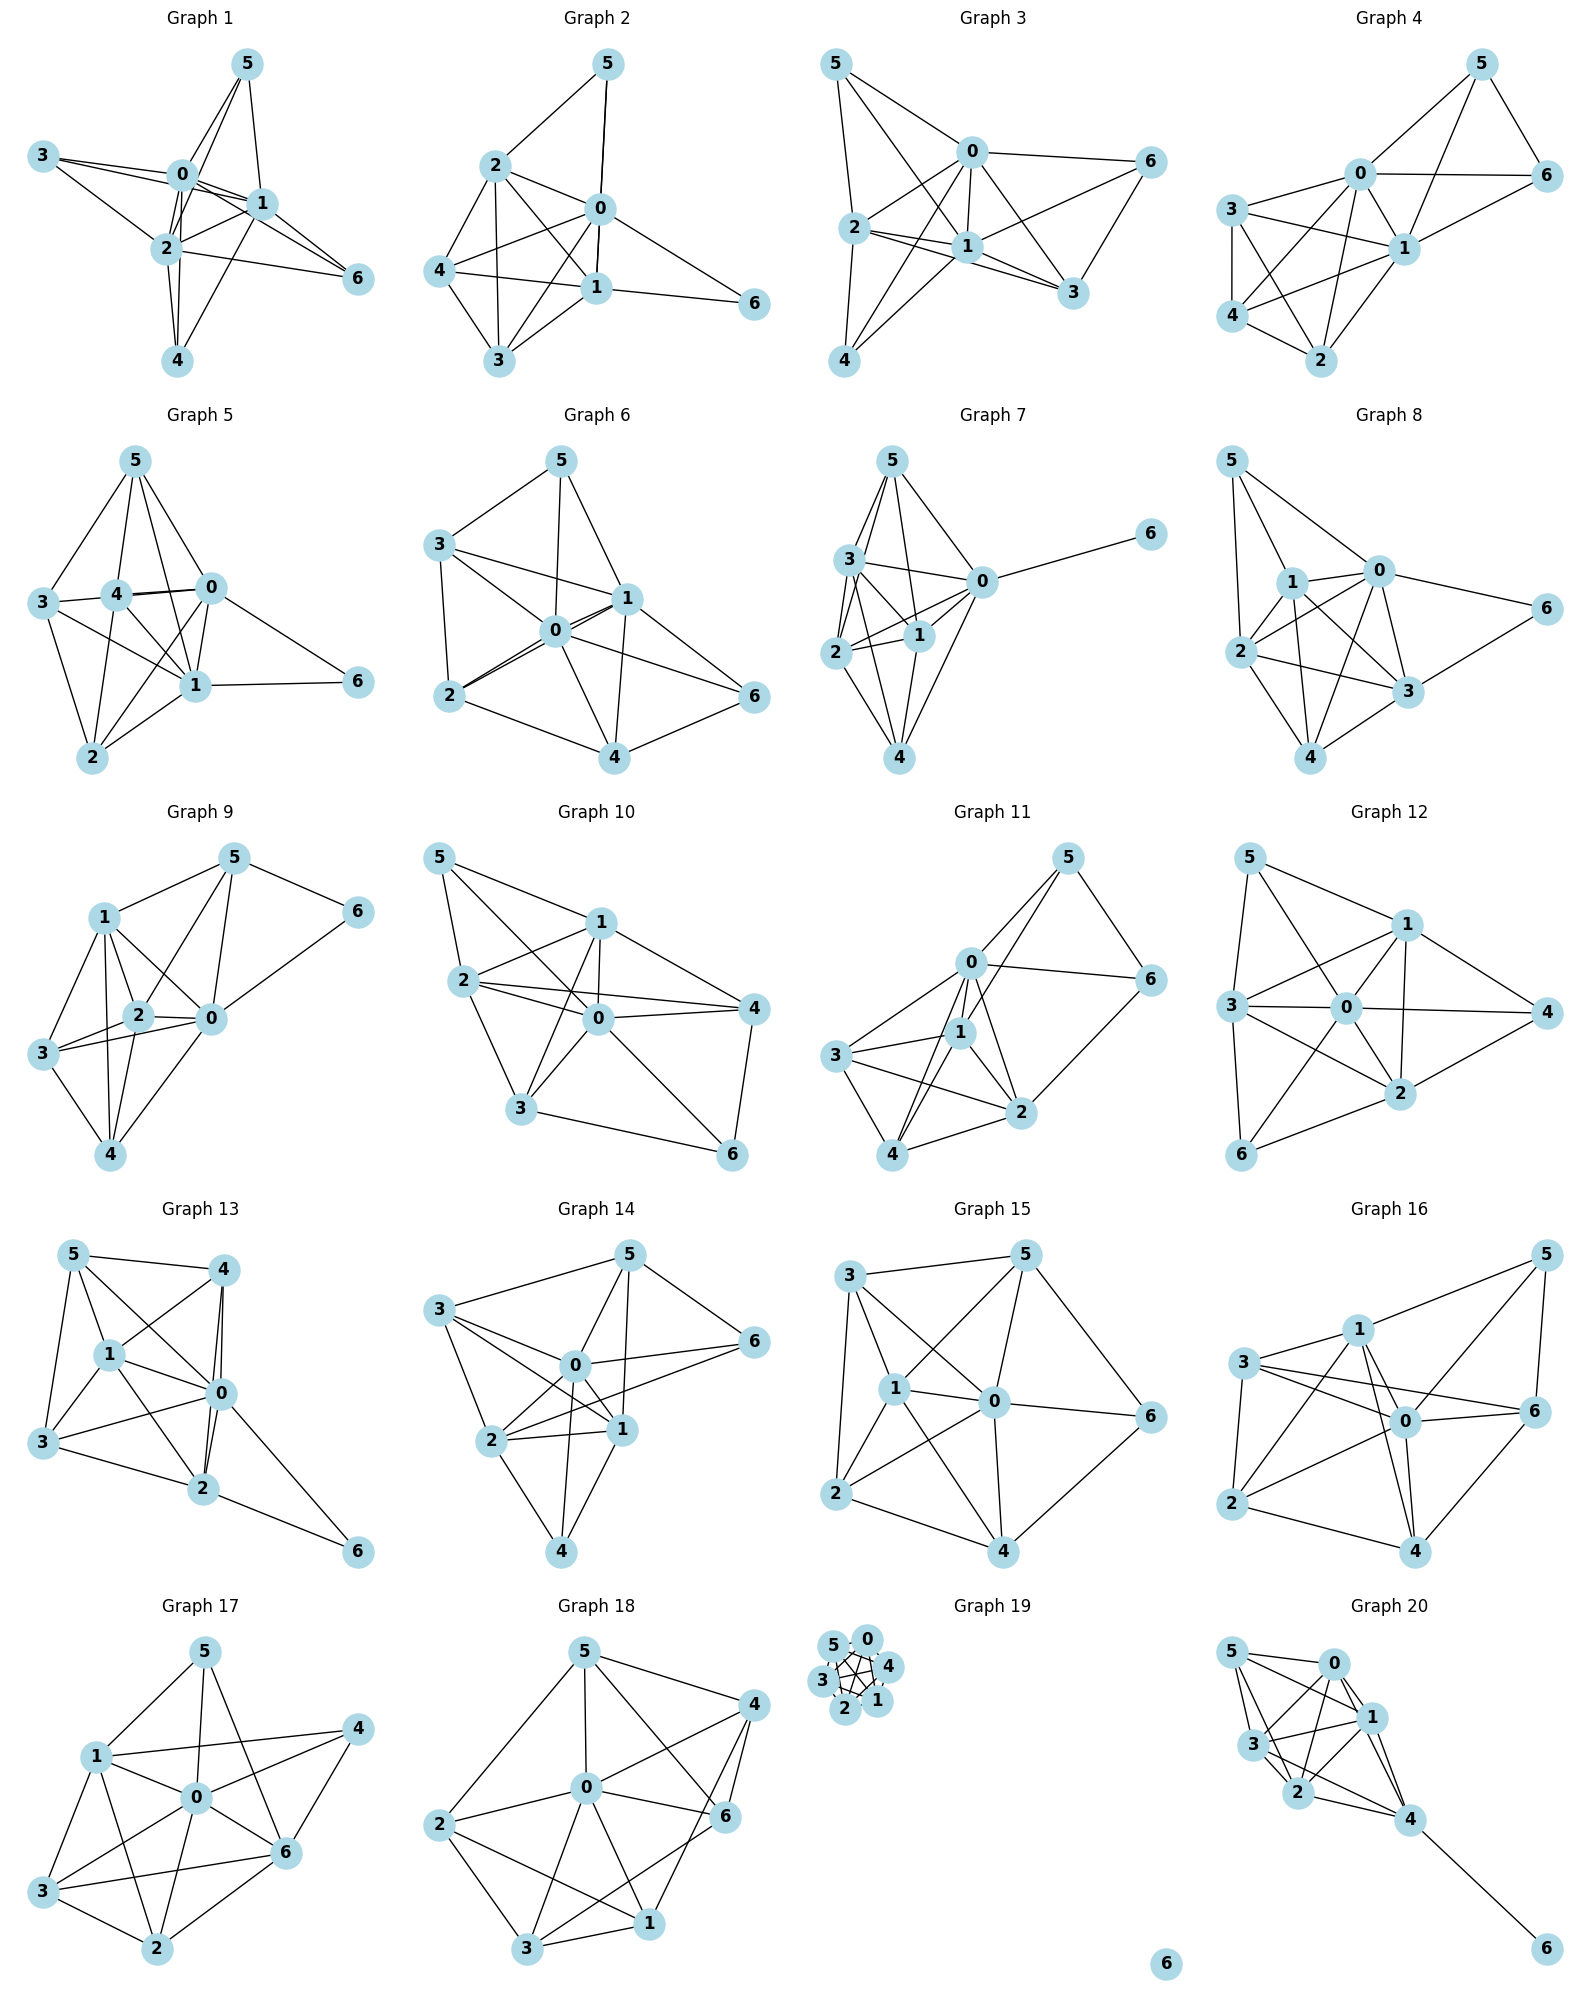

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from tqdm.notebook import tqdm  # 进度条
import time


def generate_all_graphs(num_vertices, num_edges, max_graphs=100, timeout=30):
    """
    生成具有指定顶点数和边数的非同构图，带有限制和超时机制

    参数:
        num_vertices: 顶点数
        num_edges: 边数
        max_graphs: 最大生成图数量
        timeout: 超时时间（秒）

    返回:
        非同构图列表
    """
    # 检查边数是否合法
    max_edges = num_vertices * (num_vertices - 1) // 2
    if num_edges > max_edges:
        raise ValueError(f"边数超过最大可能值 {max_edges}")

    # 所有可能的边
    all_possible_edges = list(combinations(range(num_vertices), 2))

    # 使用图的规范形式去除同构图
    unique_graphs = []
    seen_hashes = set()

    # 使用NetworkX的更高效的同构检查
    def get_graph_signature(G):
        # 使用图的特性作为签名
        return (tuple(sorted([G.degree(n) for n in G.nodes()])),
                tuple(sorted([G.degree(u) + G.degree(v) for u, v in G.edges()])))

    # 计算组合总数
    total_combinations = min(1000, sum(1 for _ in combinations(all_possible_edges, num_edges)))

    # 创建进度条
    pbar = tqdm(total=total_combinations, desc="生成图")

    # 设置超时时间
    start_time = time.time()
    count = 0

    # 从所有可能的边中选择num_edges条边
    for edges in combinations(all_possible_edges, num_edges):
        # 检查是否超时或达到最大图数
        if time.time() - start_time > timeout or len(unique_graphs) >= max_graphs:
            print(f"已达到限制条件（时间: {time.time() - start_time:.1f}秒, 图数量: {len(unique_graphs)}）")
            break

        G = nx.Graph()
        G.add_nodes_from(range(num_vertices))
        G.add_edges_from(edges)

        # 使用更高效的图签名
        sig = get_graph_signature(G)
        if sig not in seen_hashes:
            seen_hashes.add(sig)
            unique_graphs.append(G)

        count += 1
        if count % 10 == 0:  # 每10次更新一次进度条
            pbar.update(10)

    pbar.close()
    return unique_graphs


def visualize_graphs(graphs, max_display=20):
    """
    可视化一组图，限制显示数量

    参数:
        graphs: 图列表
        max_display: 最多显示的图数量
    """
    if len(graphs) > max_display:
        print(f"图数量过多，仅显示前 {max_display} 个")
        graphs = graphs[:max_display]

    num_graphs = len(graphs)

    # 计算行数和列数以优化布局
    cols = min(4, num_graphs)
    rows = (num_graphs + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # 使用更简单的布局算法
    for i, G in enumerate(graphs):
        if i < len(axes):
            ax = axes[i]

            # 使用更快速的布局
            if len(G) <= 10:
                pos = nx.spring_layout(G, seed=42, iterations=50)
            else:
                pos = nx.kamada_kawai_layout(G)

            nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue',
                    node_size=500, font_weight='bold')
            ax.set_title(f"Graph {i + 1}")

    # 隐藏多余的子图
    for i in range(num_graphs, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()


def main():
    # 用户输入顶点数和边数
    num_vertices = int(input("请输入顶点数: "))

    max_edges = num_vertices * (num_vertices - 1) // 2
    print(f"对于 {num_vertices} 个顶点，最多可以有 {max_edges} 条边")

    num_edges = int(input(f"请输入边数 (0-{max_edges}): "))

    # 设置限制参数
    max_graphs = int(input("最多生成多少个图 (建议: 100): "))
    timeout = int(input("计算超时时间（秒）(建议: 30): "))

    print(f"生成具有 {num_vertices} 个顶点和 {num_edges} 条边的非同构图...")
    graphs = generate_all_graphs(num_vertices, num_edges, max_graphs, timeout)
    print(f"共找到 {len(graphs)} 个非同构图")

    visualize_graphs(graphs)


# 执行主函数
main()

生成具有 8 个顶点，度数为 3 的非同构正则图...
共找到 10 个非同构正则图


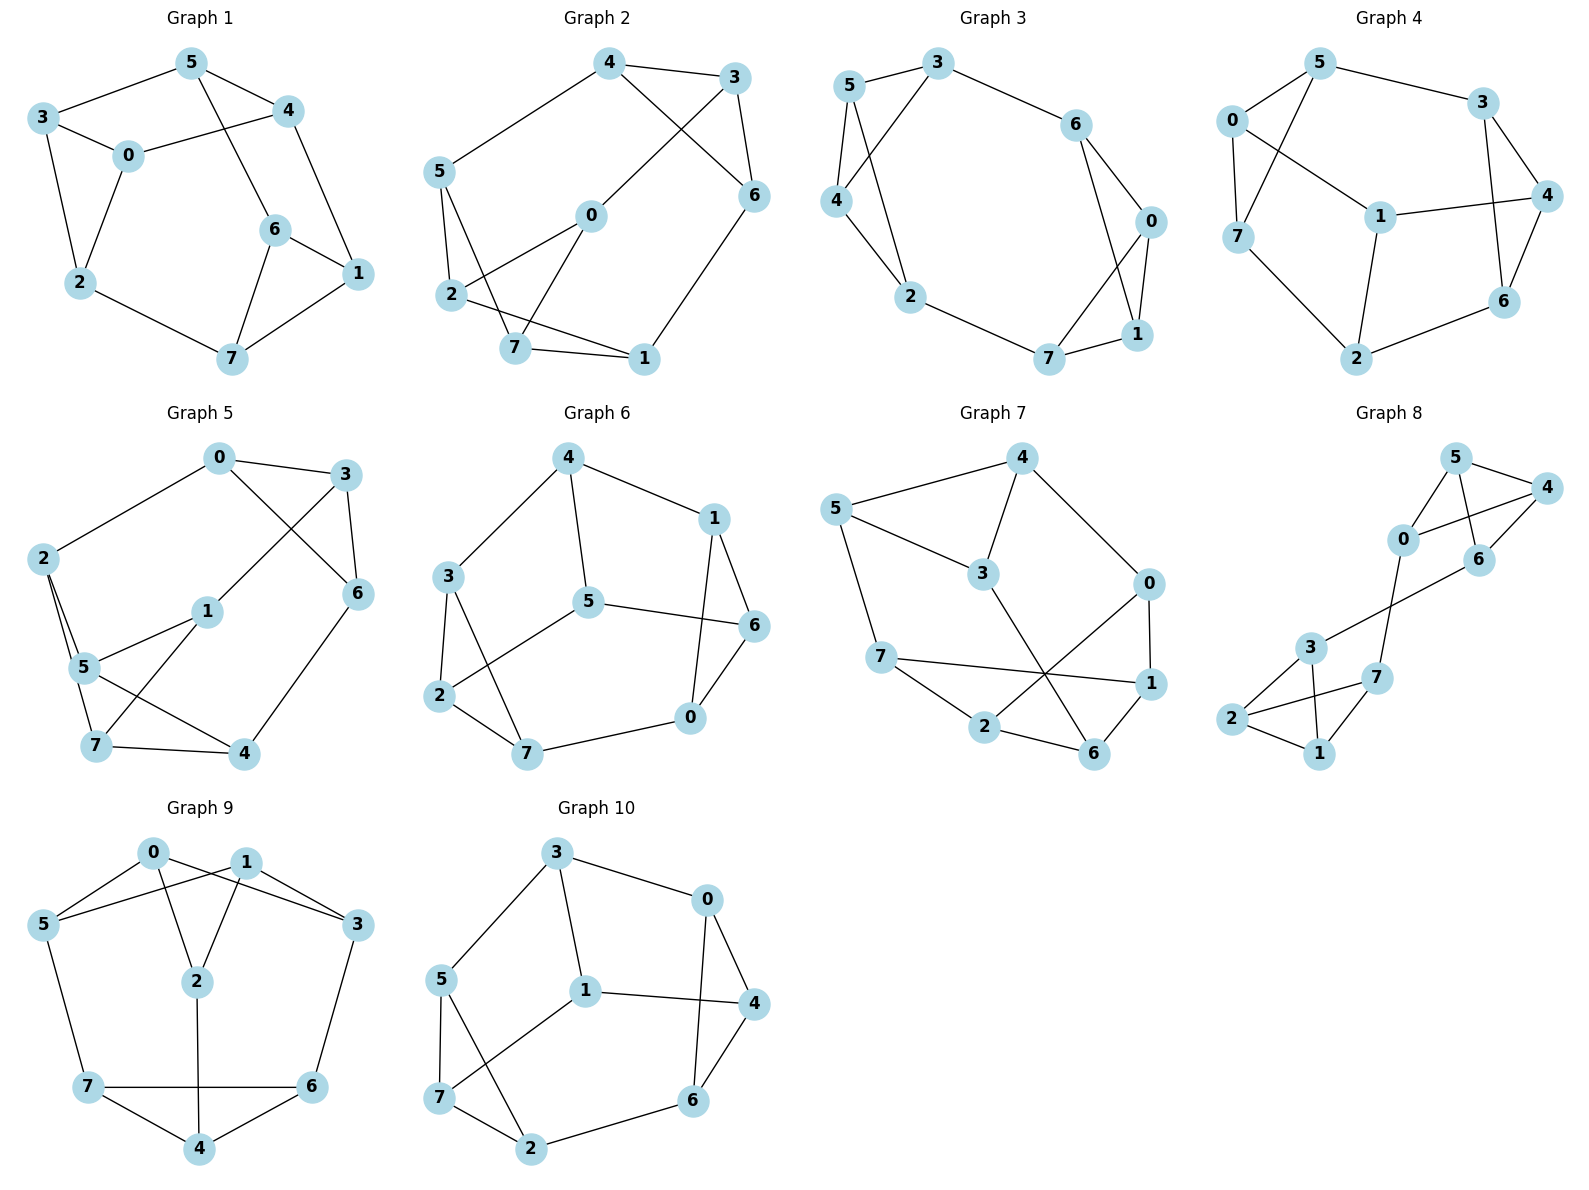

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from tqdm.notebook import tqdm
import time


def generate_regular_graphs(num_vertices, degree, max_graphs=100, timeout=30):
    """
    生成具有指定顶点数和度数的非同构正则图

    参数:
        num_vertices: 顶点数
        degree: 每个顶点的度数
        max_graphs: 最大生成图数量
        timeout: 超时时间（秒）

    返回:
        非同构正则图列表
    """
    # 检查参数有效性
    if num_vertices * degree % 2 != 0:
        raise ValueError(f"正则图要求 顶点数*度数 为偶数")

    if degree >= num_vertices:
        if degree == num_vertices - 1:
            # 完全图
            G = nx.complete_graph(num_vertices)
            return [G]
        else:
            raise ValueError(f"度数必须小于顶点数")

    # 计算边数
    num_edges = (num_vertices * degree) // 2

    # 使用NetworkX的内置函数生成正则图
    try:
        # 尝试使用NetworkX的内置函数
        start_time = time.time()
        regular_graphs = list(nx.generators.random_graphs.random_regular_graph(degree, num_vertices, seed=None)
                              for _ in range(min(10, max_graphs)))

        # 去除同构的图
        unique_graphs = []
        seen_hashes = set()

        def get_graph_signature(G):
            # 使用图特征作为签名
            return tuple(sorted([tuple(sorted(G.neighbors(n))) for n in sorted(G.nodes())]))

        for G in regular_graphs:
            sig = get_graph_signature(G)
            if sig not in seen_hashes:
                seen_hashes.add(sig)
                unique_graphs.append(G)

            if time.time() - start_time > timeout or len(unique_graphs) >= max_graphs:
                break

        return unique_graphs

    except:
        print("使用一般方法生成正则图...")
        # 如果内置函数失败，使用组合方法
        return generate_regular_graphs_combinatorial(num_vertices, degree, max_graphs, timeout)


def generate_regular_graphs_combinatorial(num_vertices, degree, max_graphs=100, timeout=30):
    """使用组合方法生成正则图"""
    all_possible_edges = list(combinations(range(num_vertices), 2))
    unique_graphs = []
    seen_hashes = set()

    def get_graph_signature(G):
        return tuple(sorted([G.degree(n) for n in G.nodes()]))

    start_time = time.time()
    num_edges = (num_vertices * degree) // 2

    # 使用NetworkX的图形生成器
    for i in range(1000):  # 尝试多次
        if time.time() - start_time > timeout or len(unique_graphs) >= max_graphs:
            break

        # 创建一个随机图作为起点
        G = nx.gnm_random_graph(num_vertices, num_edges)

        # 调整图使其变为正则图
        for _ in range(100):  # 尝试调整多次
            irregular_nodes = [n for n, d in G.degree() if d != degree]
            if not irregular_nodes:
                # 图已经是正则的
                break

            # 选择度数不正确的节点进行调整
            for node in irregular_nodes:
                current_degree = G.degree(node)

                if current_degree > degree:
                    # 删除一条边
                    neighbors = list(G.neighbors(node))
                    if neighbors:
                        G.remove_edge(node, neighbors[0])
                elif current_degree < degree:
                    # 添加一条边
                    non_neighbors = [n for n in G.nodes() if n != node and not G.has_edge(node, n)
                                     and G.degree(n) < degree]
                    if non_neighbors:
                        G.add_edge(node, non_neighbors[0])

        # 检查图是否是正则图
        if all(d == degree for n, d in G.degree()):
            sig = get_graph_signature(G)
            if sig not in seen_hashes:
                seen_hashes.add(sig)
                unique_graphs.append(G)

    return unique_graphs


def visualize_graphs(graphs, max_display=20):
    """可视化一组图，限制显示数量"""
    if len(graphs) > max_display:
        print(f"图数量过多，仅显示前 {max_display} 个")
        graphs = graphs[:max_display]

    num_graphs = len(graphs)
    cols = min(4, num_graphs)
    rows = (num_graphs + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, G in enumerate(graphs):
        if i < len(axes):
            ax = axes[i]
            pos = nx.spring_layout(G, seed=42, iterations=50)
            nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue',
                    node_size=500, font_weight='bold')
            ax.set_title(f"Graph {i + 1}")

    for i in range(num_graphs, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()


def main():
    # 用户输入顶点数和度数
    num_vertices = int(input("请输入顶点数: "))
    degree = int(input(f"请输入顶点的度数 (必须小于{num_vertices}): "))

    # 检查是否满足n*k为偶数
    if num_vertices * degree % 2 != 0:
        print(f"错误: 顶点数({num_vertices}) * 度数({degree}) = {num_vertices * degree}，不是偶数。")
        print("根据图论，正则图要求 顶点数*度数 为偶数。")
        return

    # 设置限制参数
    max_graphs = int(input("最多生成多少个图 (建议: 20): "))
    timeout = int(input("计算超时时间（秒）(建议: 30): "))

    print(f"生成具有 {num_vertices} 个顶点，度数为 {degree} 的非同构正则图...")
    graphs = generate_regular_graphs(num_vertices, degree, max_graphs, timeout)
    print(f"共找到 {len(graphs)} 个非同构正则图")

    visualize_graphs(graphs)


# 执行主函数
if __name__ == "__main__":
    main()